In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import requests
from urllib.error import HTTPError

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

%pylab inline
%matplotlib inline
matplotlib.style.use('fivethirtyeight')


Populating the interactive namespace from numpy and matplotlib


### Data Schema Analysis

In [5]:
# importing of data
endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'
count = 1000
pages = 200

results = []
params = {'$limit': count, '$offset': 0}

for i in range(0, pages):
    
    try:
        r = requests.get(endpoint, params=params)
        results.append(r.json())
        params['$offset'] = count
        count += 1000
        
    except HTTPError as err:
        if err.response.status_code == '404':
            break
        else:
            print(err.response.status_code)

len(results)

200

In [6]:
outcome_df = pd.DataFrame()

for i in results:
    outcome_df = outcome_df.append(pd.io.json.json_normalize(i))

len(outcome_df)

98411

In [7]:
cats_df = outcome_df[outcome_df['animal_type'] == 'Cat'].reset_index()
del cats_df['index']

In [8]:
cats_df.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,36305,36305,36305,36305,36305,36305,36305,36305,20262,22607,36304,36305
unique,46,34670,1,91,258,4684,27391,27391,8438,17,8,5
top,2 months,A774102,Cat,Domestic Shorthair Mix,Brown Tabby,2016-04-15T00:00:00.000,2015-08-11T00:00:00.000,2015-08-11T00:00:00.000,Luna,Partner,Transfer,Spayed Female
freq,7154,7,36305,28969,5487,69,25,25,77,11341,16139,10881


In [9]:
cats_df.head(1)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 years,A792419,Cat,Domestic Medium Hair Mix,Calico,2017-04-10T00:00:00.000,2019-04-14T18:36:00.000,2019-04-14T18:36:00.000,NaN,Snr,Transfer,Intact Female


In [10]:
# remove if outcome is nan
cats_df = cats_df.dropna(subset=['outcome_type'])

In [11]:
len(cats_df)

36304

### Clean Up

In [12]:
cats_df['count'] = 1

In [13]:
cats_df['sex_upon_outcome'].unique()

array(['Intact Female', 'Intact Male', 'Spayed Female', 'Neutered Male',
       'Unknown'], dtype=object)

In [14]:
cats_df['male'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 1, 0)
cats_df['female'] = np.where(cats_df['sex_upon_outcome'].str.contains('Male'), 0, 1)
cats_df['spayed_or_neutered'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 0, 1)
cats_df['intact'] = np.where(cats_df['sex_upon_outcome'].str.contains('Intact'), 1, 0)

In [15]:
cats_df['age_upon_outcome'].head()

0     2 years
1      1 year
2     7 years
3      2 days
4    5 months
Name: age_upon_outcome, dtype: object

In [16]:
cats_df = cats_df[cats_df['age_upon_outcome'] != 'NULL']
cats_df['Periods'], cats_df['Period Range'] = cats_df['age_upon_outcome'].str.split(' ').str[0].fillna(0).astype(int), cats_df['age_upon_outcome'].str.split(' ').str[1].fillna(0)

In [17]:
cats_df['Period Range'].unique()

array(['years', 'year', 'days', 'months', 'weeks', 'week', 'day', 'month'],
      dtype=object)

In [18]:
cats_df['Period Range'] = np.where(cats_df['Period Range'].str.contains('day'), 1, 
                                   np.where(cats_df['Period Range'].str.contains('week'), 7, 
                                            np.where(cats_df['Period Range'].str.contains('month'), 30, 
                                                     np.where(cats_df['Period Range'].str.contains('year'), 365, 0)))).astype(int)

cats_df['outcome_age_(days)'] = cats_df['Period Range'] * cats_df['Periods']
cats_df['outcome_age_(years)'] = cats_df['outcome_age_(days)'] / 365

In [19]:
cats_df['Cat'] = np.where(cats_df['outcome_age_(days)'] >= 180, 1, 0)
cats_df['Kitten'] = np.where(cats_df['outcome_age_(days)'] >= 180, 0, 1)

In [20]:
cats_df['age_group'] = pd.cut(cats_df['outcome_age_(years)'], 8)
cats_df['age_group'].value_counts()

(-0.022, 2.75]    30848
(2.75, 5.5]        2612
(5.5, 8.25]        1373
(8.25, 11.0]        786
(11.0, 13.75]       378
(13.75, 16.5]       233
(16.5, 19.25]        56
(19.25, 22.0]        17
Name: age_group, dtype: int64

In [21]:
cats_df['date_of_birth'] = pd.to_datetime(cats_df['date_of_birth'])

cats_df['dob_year'] = cats_df['date_of_birth'].dt.year
cats_df['dob_month'] = cats_df['date_of_birth'].dt.month
cats_df['dob_monthyear'] = pd.to_datetime(cats_df['monthyear']).dt.to_period('M')

cats_df['datetime'] = pd.to_datetime(cats_df['datetime'])
cats_df['outcome_month'] = cats_df['datetime'].dt.month
cats_df['outcome_year'] = cats_df['datetime'].dt.year
cats_df['outcome_weekday'] = cats_df['datetime'].dt.weekday_name
cats_df['outcome_hour'] = cats_df['datetime'].dt.hour

In [22]:
cats_df['breed'] = cats_df['breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

In [23]:
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

In [24]:
cats_df = pd.concat([cats_df, 
                     cats_df['breed'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

cats_df['cfa_breed'] = np.where((cats_df['breed1'].str.contains(cfa_breeds)) | 
                                (cats_df['breed2'].str.contains(cfa_breeds)), 
                                1, 0)

cats_df['domestic_breed'] = np.where(cats_df['cfa_breed'] == 0, 1, 0)

In [25]:
# University of Florida's Shelter Medicine
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

coat_reg = '(' + '|'.join(coat_patterns) + ')'

In [26]:
cats_df['color'] = cats_df['color'].str.lower()

cats_df['coat_pattern'] = cats_df['color'].str.extract(coat_reg, expand=False)

cats_df['color'] = cats_df['color'].str.replace(coat_reg, '').str.strip()

In [27]:
cats_df = pd.concat([cats_df, 
                     cats_df['color'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

cats_df['color1'] = np.where(cats_df['color1'] == '', 'Breed Specific', cats_df['color1'])

cats_df['coat'] = np.where(cats_df['color1'] == 'Breed Specific', cats_df['coat_pattern'], cats_df['color1'])

In [28]:
cats_df['name'].value_counts()[0:20]

Luna        77
Bella       65
Smokey      53
Charlie     53
Kitty       53
Lucy        49
Oliver      47
Tiger       44
Shadow      42
*Charlie    41
Oreo        38
Blue        38
Max         35
Milo        35
Princess    35
X           34
Leo         34
Lily        32
*Molly      32
*Jack       31
Name: name, dtype: int64

In [29]:
cats_df['number_of_visits'] = cats_df.groupby('animal_id')['animal_id'].transform('count')

In [30]:
cats_df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,outcome_hour,breed1,breed2,cfa_breed,domestic_breed,coat_pattern,color1,color2,coat,number_of_visits
0,2 years,A792419,Cat,domestic mediumhair,,2017-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,NaN,Snr,...,18,domestic mediumhair,None,0,1,calico,Breed Specific,None,calico,1
1,1 year,A792450,Cat,domestic shorthair,orange,2018-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,NaN,Snr,...,18,domestic shorthair,None,0,1,tabby,orange,None,orange,1
2,7 years,A791174,Cat,domestic shorthair,,2012-03-22,2019-04-14 17:41:00,2019-04-14T17:41:00.000,Tintin,NaN,...,17,domestic shorthair,None,0,1,tortie,Breed Specific,None,tortie,1
3,2 days,A792724,Cat,domestic shorthair,blue,2019-04-12,2019-04-14 16:54:00,2019-04-14T16:54:00.000,NaN,Partner,...,16,domestic shorthair,None,0,1,tabby,blue,None,blue,1
4,5 months,A792566,Cat,domestic shorthair,blue,2018-11-12,2019-04-14 16:45:00,2019-04-14T16:45:00.000,NaN,NaN,...,16,domestic shorthair,None,0,1,tabby,blue,None,blue,1


In [31]:
cats_df = cats_df.drop(columns=['Period Range', 'Periods', 'sex_upon_outcome', 'age_upon_outcome', 'animal_type', 'breed1', 'breed2', 'coat', 'color1', 'color2', 'breed', 'name'])

In [32]:
# make outcomes numeric
cats_df['outcome_type'].unique()
np.where((cats_df['outcome_type'].str.contains('Adoption')), 1, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Died')), 2, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Return to Owner')), 3, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Transfer')), 4, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Euthanasia')), 5, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Rto-Adopt')), 6, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Missing')), 7, cats_df['outcome_type'])
np.where((cats_df['outcome_type'].str.contains('Disposal')), 8, cats_df['outcome_type'])


array(['Transfer', 'Adoption', 'Return to Owner', 'Euthanasia',
       'Disposal', 'Died', 'Rto-Adopt', 'Missing'], dtype=object)

array(['Transfer', 'Transfer', 1, ..., 'Transfer', 'Transfer', 'Transfer'],
      dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array([4, 4, 'Adoption', ..., 4, 4, 4], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

array(['Transfer', 'Transfer', 'Adoption', ..., 'Transfer', 'Transfer',
       'Transfer'], dtype=object)

In [33]:
cats_df['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Return to Owner', 'Euthanasia',
       'Disposal', 'Died', 'Rto-Adopt', 'Missing'], dtype=object)

In [34]:
cats_df['adopted'] = np.where(cats_df['outcome_type'].str.contains('Adoption'), 1, 0)
cats_df['died'] = np.where(cats_df['outcome_type'].str.contains('Died'), 1, 0)
cats_df['returned'] = np.where(cats_df['outcome_type'].str.contains('Return to Owner'), 1, 0)
cats_df['transferred'] = np.where(cats_df['outcome_type'].str.contains('Transfer'), 1, 0)
cats_df['euthanised'] = np.where(cats_df['outcome_type'].str.contains('Euthanasia'), 1, 0)
cats_df['rto-adopted'] = np.where(cats_df['outcome_type'].str.contains('Rto-Adopt'), 1, 0)
cats_df['missing'] = np.where(cats_df['outcome_type'].str.contains('Missing'), 1, 0)
cats_df['disposed'] = np.where(cats_df['outcome_type'].str.contains('Disposal'), 1, 0)

In [35]:
cats_df['coat_pattern'].unique()

array(['calico', 'tabby', 'tortie', nan, 'smoke', 'point', 'torbie',
       'tricolor', 'agouti', 'brindle'], dtype=object)

In [36]:
cats_df['tabby'] = np.where(cats_df['coat_pattern'].str.contains('tabby'), 1, 0)
cats_df['tricolor'] = np.where(cats_df['coat_pattern'].str.contains('tricolor'), 0, 1)
cats_df['agouti'] = np.where(cats_df['coat_pattern'].str.contains('agouti'), 0, 1)
cats_df['calico'] = np.where(cats_df['coat_pattern'].str.contains('calico'), 1, 0)
cats_df['brindle'] = np.where(cats_df['coat_pattern'].str.contains('brindle'), 1, 0)
cats_df['tortie'] = np.where(cats_df['coat_pattern'].str.contains('tortie'), 0, 1)
cats_df['torbie'] = np.where(cats_df['coat_pattern'].str.contains('torbie'), 0, 1)
cats_df['point'] = np.where(cats_df['coat_pattern'].str.contains('point'), 1, 0)
cats_df['smoke'] = np.where(cats_df['coat_pattern'].str.contains('smoke'), 1, 0)
cats_df['other'] = np.where(cats_df['coat_pattern'].str.contains('other'), 1, 0)

In [37]:
cats_df['is_old'] = np.where(cats_df['outcome_age_(years)'] > 10, 1, 0)
cats_df['had_multiple_visits'] = np.where(cats_df['number_of_visits'] > 1, 1, 0)

In [38]:
cats_df.head()

,animal_id,color,date_of_birth,datetime,monthyear,outcome_subtype,outcome_type,count,male,female,...,agouti,calico,brindle,tortie,torbie,point,smoke,other,is_old,had_multiple_visits
0,A792419,,2017-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,Snr,Transfer,1,0,1,...,1,1,0,1,1,0,0,0,0,0
1,A792450,orange,2018-04-10,2019-04-14 18:36:00,2019-04-14T18:36:00.000,Snr,Transfer,1,1,0,...,1,0,0,1,1,0,0,0,0,0
2,A791174,,2012-03-22,2019-04-14 17:41:00,2019-04-14T17:41:00.000,NaN,Adoption,1,0,1,...,1,0,0,0,1,0,0,0,0,0
3,A792724,blue,2019-04-12,2019-04-14 16:54:00,2019-04-14T16:54:00.000,Partner,Transfer,1,1,0,...,1,0,0,1,1,0,0,0,0,0
4,A792566,blue,2018-11-12,2019-04-14 16:45:00,2019-04-14T16:45:00.000,NaN,Adoption,1,1,0,...,1,0,0,1,1,0,0,0,0,0


In [39]:
cats_df['number_of_visits'].value_counts()

1    33199
2     2644
3      396
4       52
7        7
5        5
Name: number_of_visits, dtype: int64

In [40]:
cats_df.columns.values

array(['animal_id', 'color', 'date_of_birth', 'datetime', 'monthyear',
       'outcome_subtype', 'outcome_type', 'count', 'male', 'female',
       'spayed_or_neutered', 'intact', 'outcome_age_(days)',
       'outcome_age_(years)', 'Cat', 'Kitten', 'age_group', 'dob_year',
       'dob_month', 'dob_monthyear', 'outcome_month', 'outcome_year',
       'outcome_weekday', 'outcome_hour', 'cfa_breed', 'domestic_breed',
       'coat_pattern', 'number_of_visits', 'adopted', 'died', 'returned',
       'transferred', 'euthanised', 'rto-adopted', 'missing', 'disposed',
       'tabby', 'tricolor', 'agouti', 'calico', 'brindle', 'tortie',
       'torbie', 'point', 'smoke', 'other', 'is_old',
       'had_multiple_visits'], dtype=object)

### Basic Analysis

#### Encoding for Outcomes (use later)

In [41]:
cats_df['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Return to Owner', 'Euthanasia',
       'Disposal', 'Died', 'Rto-Adopt', 'Missing'], dtype=object)

In [42]:
data = array(cats_df['outcome_type'])

In [43]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data)

In [44]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded_outcomes = onehot_encoder.fit_transform(integer_encoded)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


#### boxplots

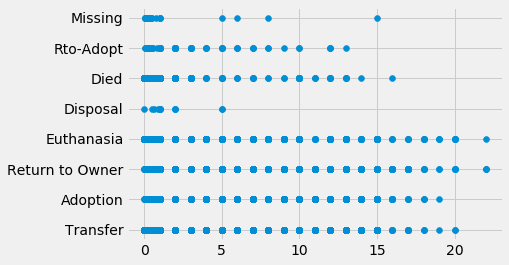

In [45]:
plt.scatter(cats_df['outcome_age_(years)'], cats_df['outcome_type'])

In [46]:
cats_df['outcome_subtype'].value_counts()

Partner           11341
Foster             4213
SCRP               3211
Snr                1585
Suffering          1444
In Kennel           272
In Foster           188
Offsite             110
Rabies Risk          73
Medical              65
At Vet               64
Enroute              20
In Surgery           10
Aggressive            4
Barn                  3
Possible Theft        2
Underage              1
Name: outcome_subtype, dtype: int64

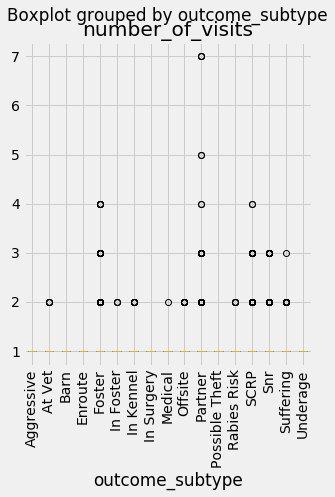

In [47]:
cats_df.boxplot('number_of_visits','outcome_subtype',rot = 90,figsize=(5,6))

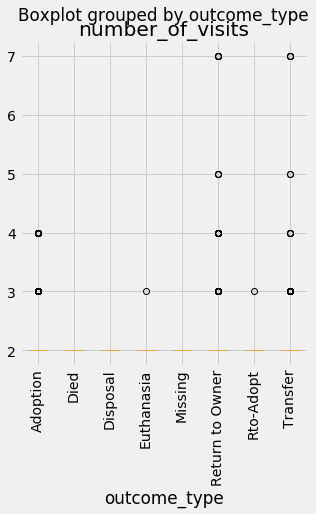

In [48]:
cats_multiple_visits = cats_df[cats_df['number_of_visits'] > 1]
cats_multiple_visits.boxplot('number_of_visits','outcome_type',rot = 90,figsize=(5,6))

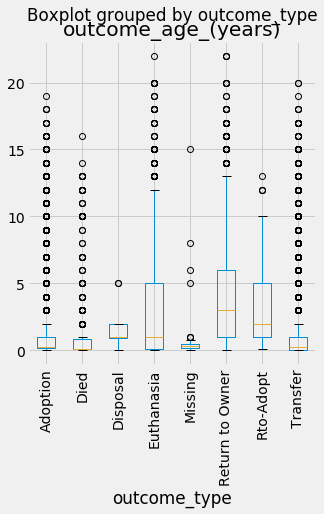

In [49]:
cats_df.boxplot('outcome_age_(years)','outcome_type',rot = 90,figsize=(5,6))

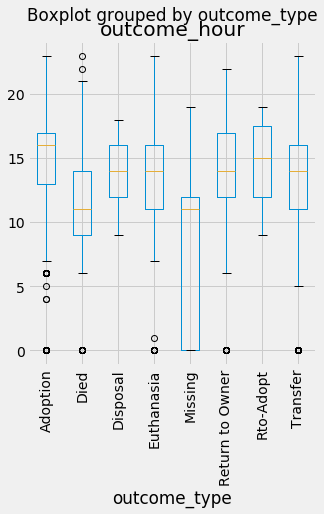

In [50]:
cats_df.boxplot('outcome_hour','outcome_type',rot = 90,figsize=(5,6))

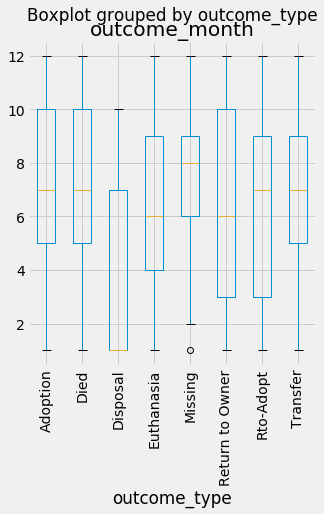

In [51]:
cats_df.boxplot('outcome_month','outcome_type',rot = 90,figsize=(5,6))

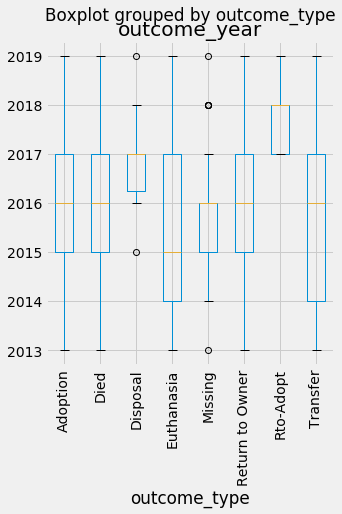

In [52]:
cats_df.boxplot('outcome_year','outcome_type',rot = 90,figsize=(5,6))


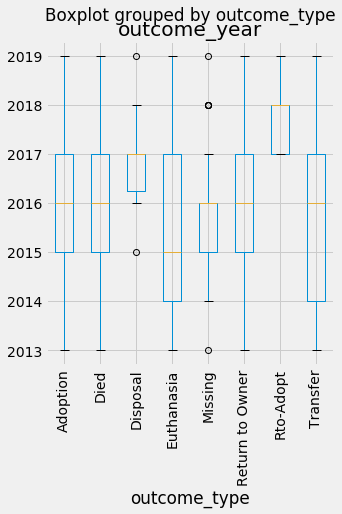

In [53]:
cats_df.boxplot('outcome_year','outcome_type',rot = 90,figsize=(5,6))


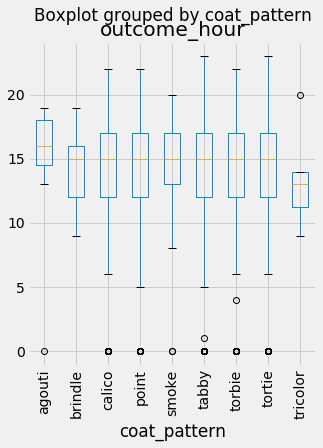

In [54]:
cats_df.boxplot('outcome_hour','coat_pattern',rot = 90,figsize=(5,6))


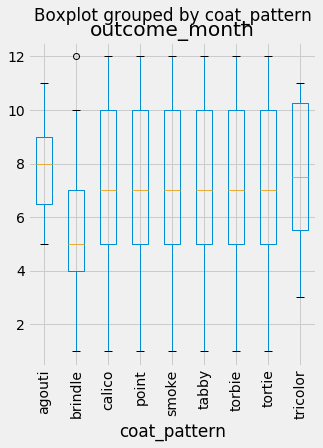

In [55]:
cats_df.boxplot('outcome_month','coat_pattern',rot = 90,figsize=(5,6))


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome Type')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Age Group')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Weekday')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Coat Pattern')

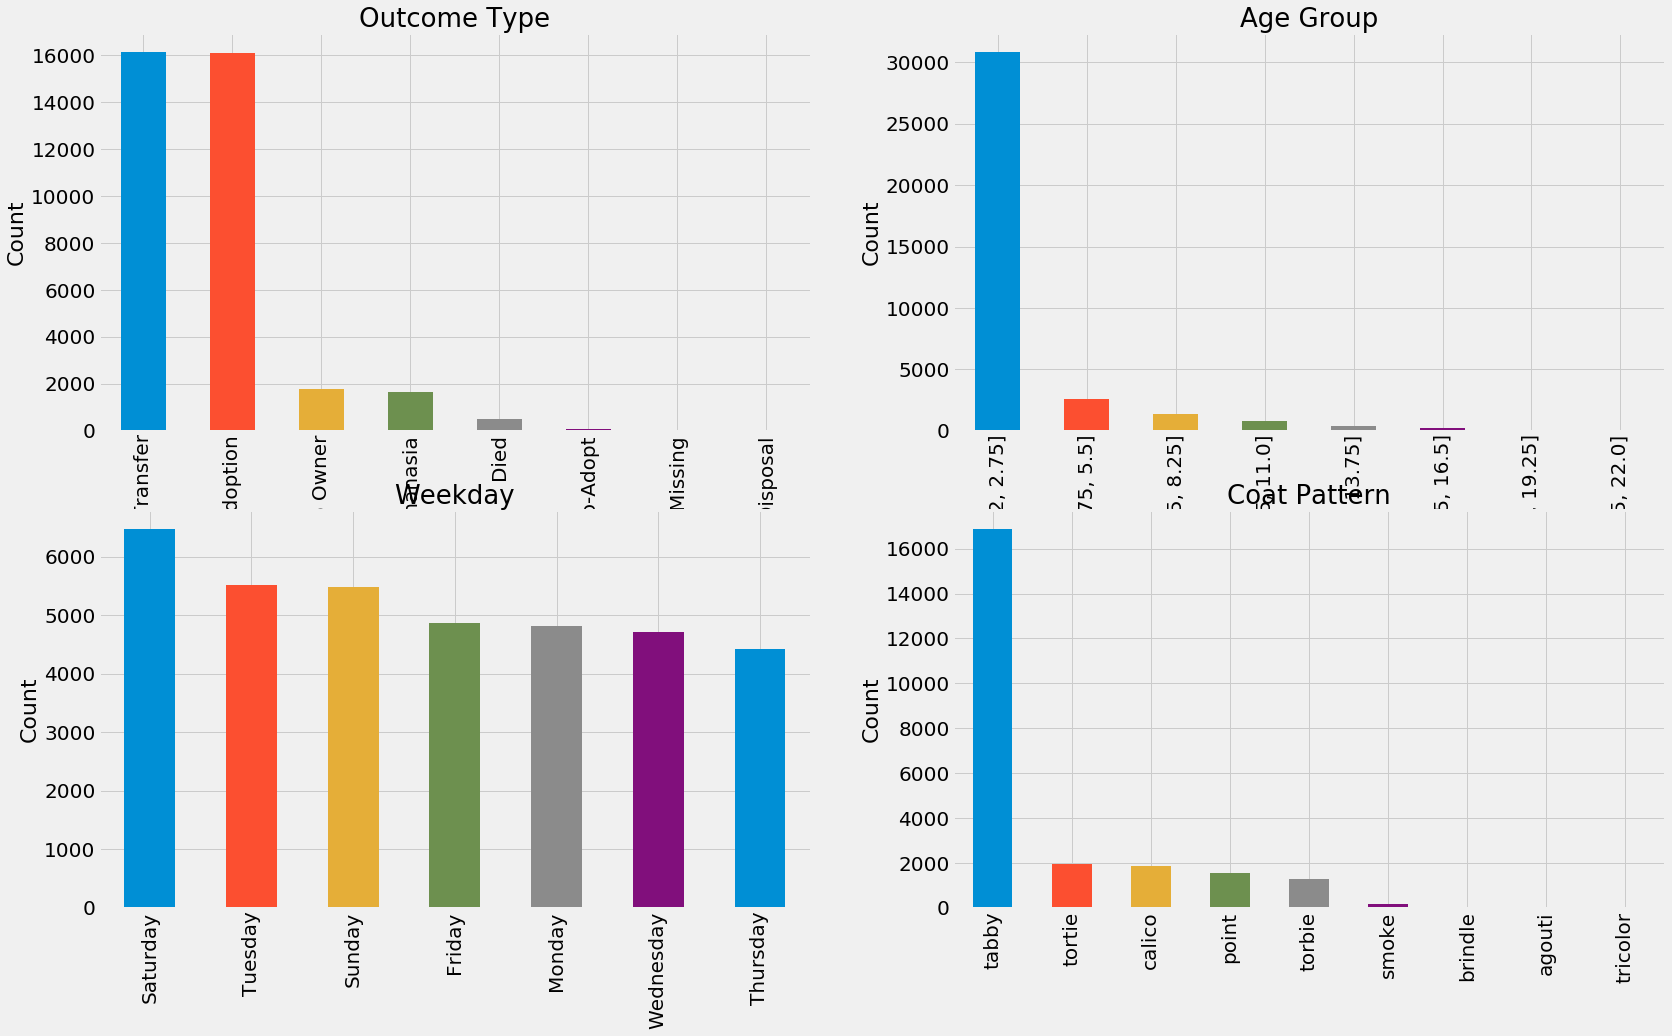

In [56]:
f, ax = plt.subplots(2, 2, figsize=(25, 15))

p1 = cats_df['outcome_type'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Outcome Type', fontsize=26)

p2 = cats_df['age_group'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Age Group', fontsize=26)

p3 = cats_df['outcome_weekday'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,0])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Weekday', fontsize=26)

p4 = cats_df['coat_pattern'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,1])
p4.set_ylabel('Count', fontsize=22)
p4.set_title('Coat Pattern', fontsize=26)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome (Year)')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome (Month)')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Outcome (Hour)')

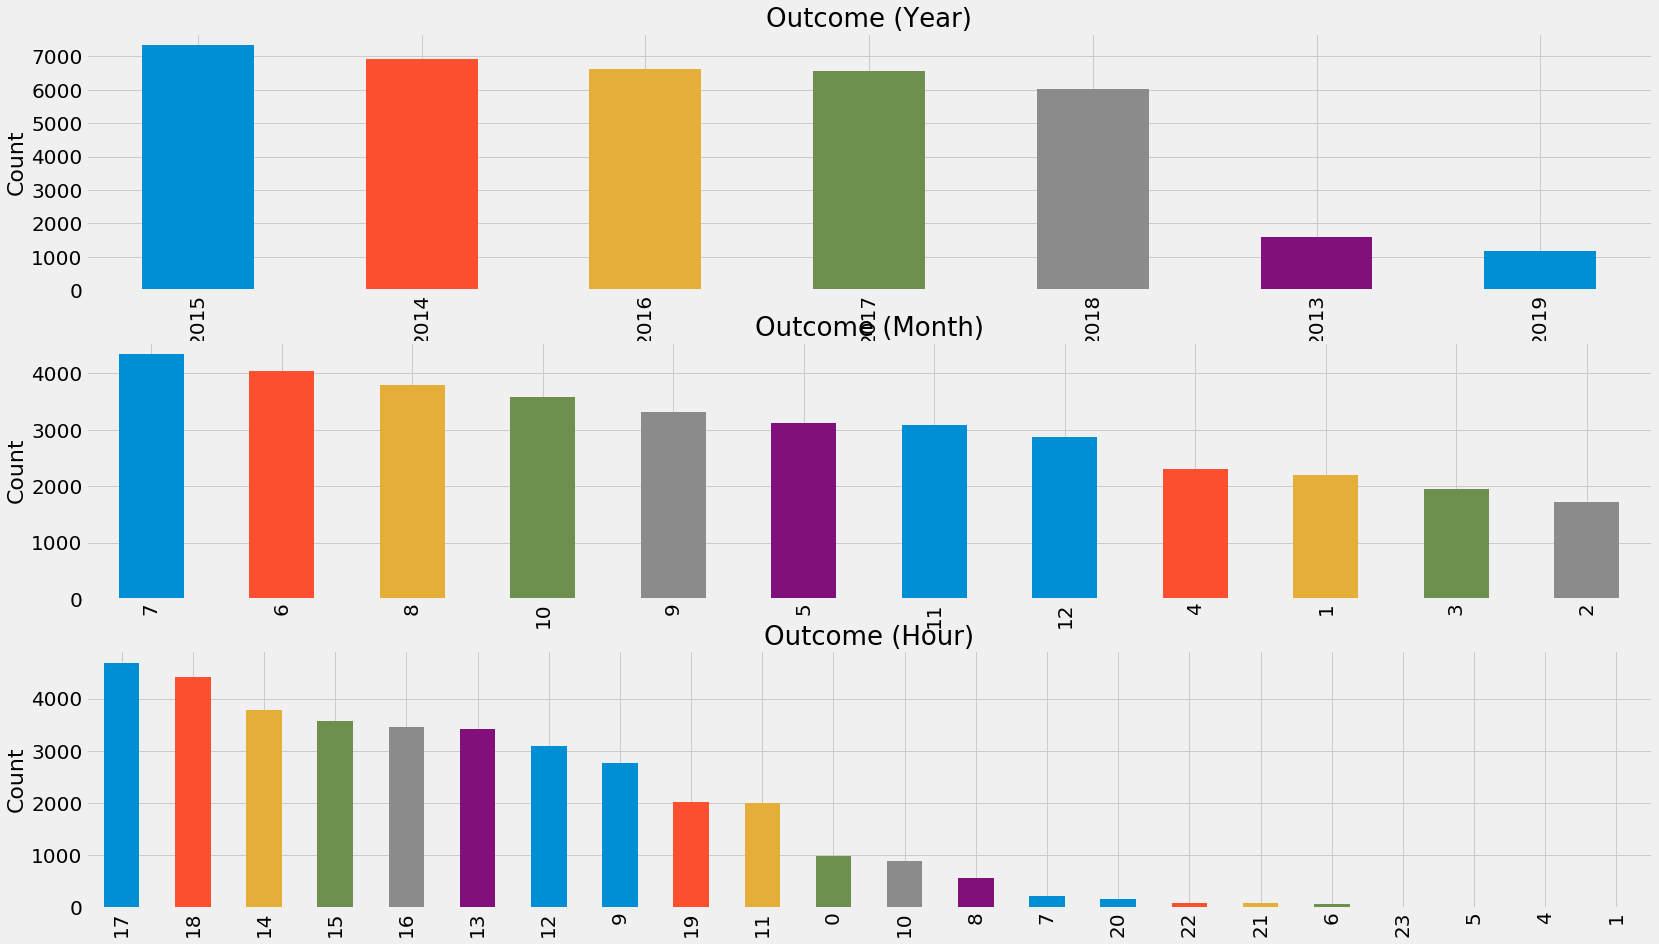

In [57]:
f, ax = plt.subplots(3, 1, figsize=(25, 15))

p1 = cats_df['outcome_year'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Outcome (Year)', fontsize=26)

p2 = cats_df['outcome_month'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Outcome (Month)', fontsize=26)

p3 = cats_df['outcome_hour'].value_counts().plot(kind='bar', fontsize=20, ax=ax[2])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Outcome (Hour)', fontsize=26)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Hourly Outcome')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Hour')

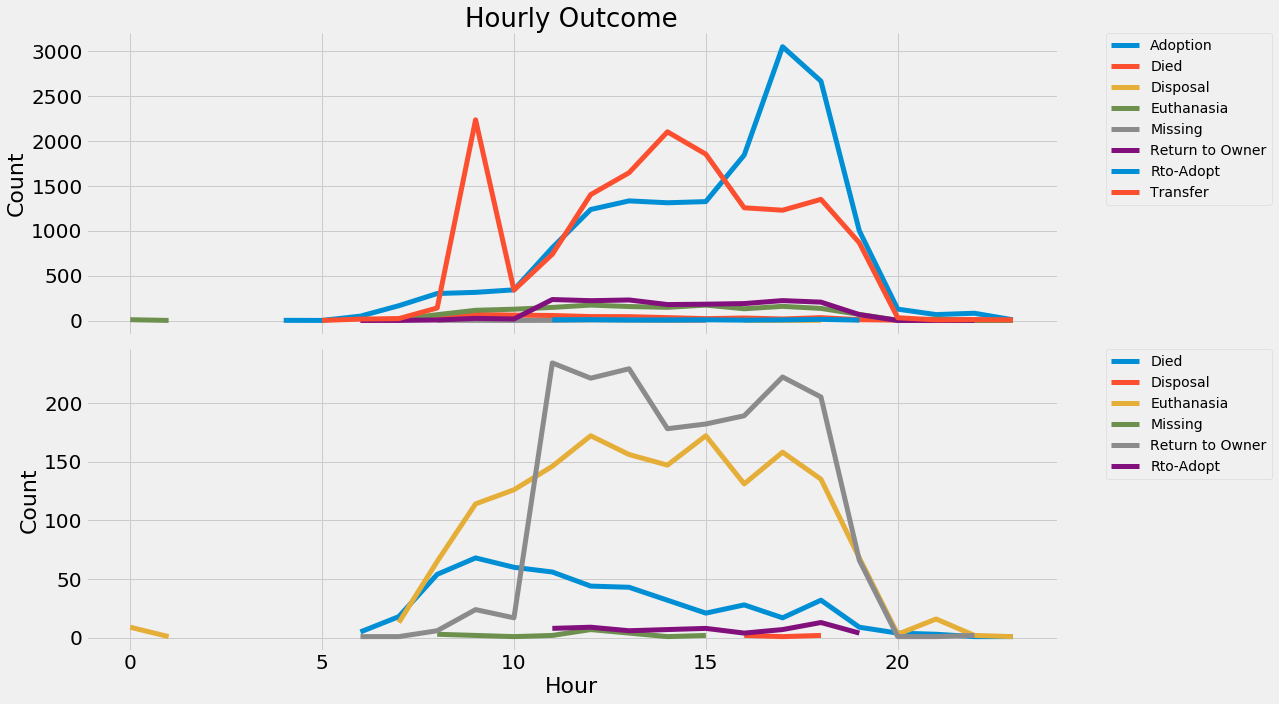

In [58]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

outcomes_not_transferred = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
outcomes_not_transferred = outcomes_not_transferred[~cats_df['outcome_type'].str.contains('Transfer')]

hourly_outcome_not_trans = pd.pivot_table(outcomes_not_transferred, 
                              index=['outcome_hour'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

p1 = hourly_outcome.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Hourly Outcome', fontsize=26)

p2 = hourly_outcome_not_trans.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Hour', fontsize=22)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Monthly Outcome Volume')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Month')

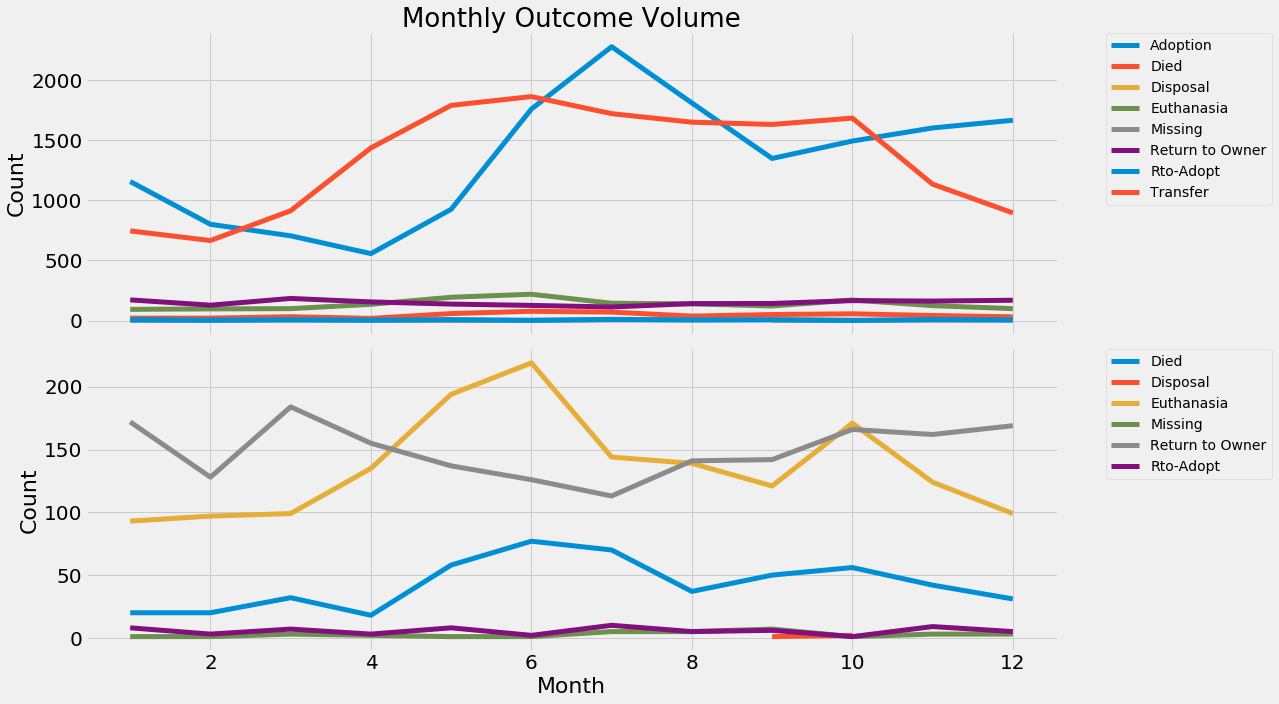

In [59]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_month'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

outcomes_not_transferred = cats_df[~cats_df['outcome_type'].str.contains('Adoption')]
outcomes_not_transferred = outcomes_not_transferred[~cats_df['outcome_type'].str.contains('Transfer')]

hourly_outcome_not_trans = pd.pivot_table(outcomes_not_transferred, 
                              index=['outcome_month'], columns=['outcome_type'], 
                              values='count', aggfunc=np.sum)

p1 = hourly_outcome.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Monthly Outcome Volume', fontsize=26)

p2 = hourly_outcome_not_trans.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Month', fontsize=22)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Some Stats

#### Conditional Probabilities

In [60]:
prob_kitten = cats_df.groupby('Kitten').size().div(len(cats_df))
cats_df.groupby(['Kitten', 'outcome_type']).size().div(len(cats_df)).div(prob_kitten)



Kitten  outcome_type   
0       Adoption           0.349319
        Died               0.009237
        Disposal           0.000852
        Euthanasia         0.066627
        Missing            0.000590
        Return to Owner    0.106263
        Rto-Adopt          0.003734
        Transfer           0.463378
1       Adoption           0.512239
        Died               0.017586
        Disposal           0.000048
        Euthanasia         0.029374
        Missing            0.001141
        Return to Owner    0.008223
        Rto-Adopt          0.000475
        Transfer           0.430914
dtype: float64

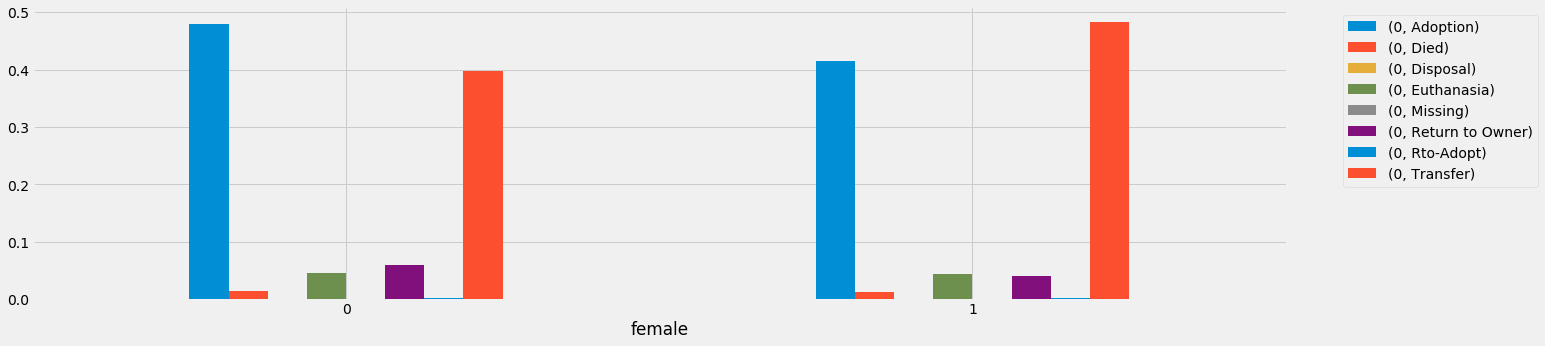

In [61]:
female_probabilities = cats_df.groupby('female').size().div(len(cats_df))
females = cats_df.groupby(['female', 'outcome_type']).size().div(len(cats_df)).div(female_probabilities)
females_df = females.to_frame()
plt = females_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


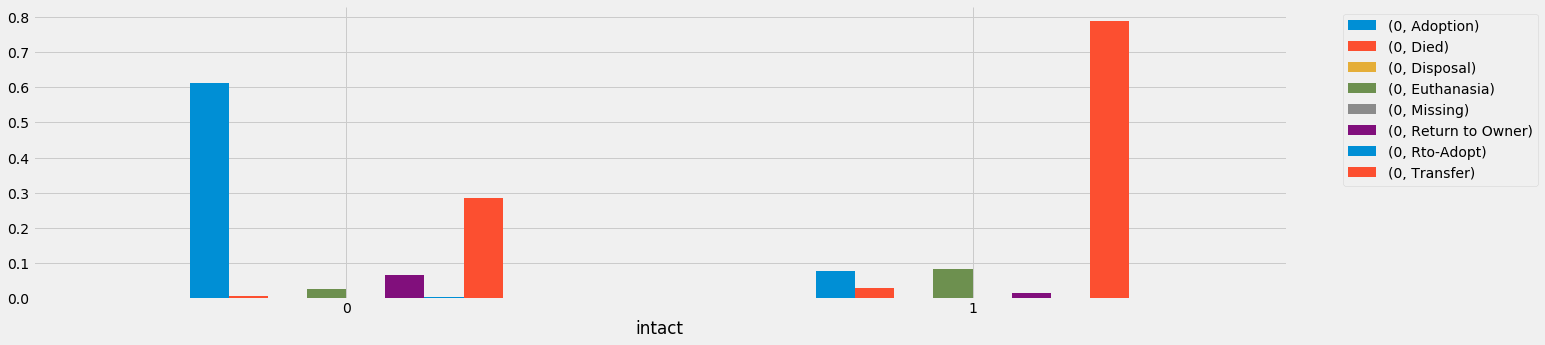

In [62]:
# Intact cats are more prone to dieing vs ones that are spayed/neutuered. Taking this one step further, intact cats
# are more likely to be really young, or very old, so there will likely be some form of correlation between these
# three variables. Something to explore?

intact_probabilities = cats_df.groupby('intact').size().div(len(cats_df))
intact = cats_df.groupby(['intact', 'outcome_type']).size().div(len(cats_df)).div(intact_probabilities)
intact_df = intact.to_frame()
plt = intact_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


Text(0.5, 1.0, 'Correlation of Variables')

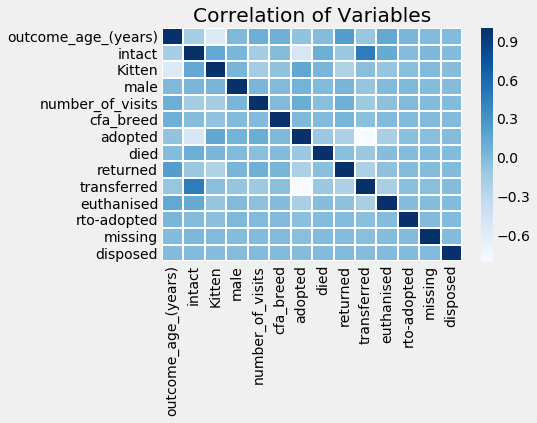

In [63]:
## exploring correlation between age_group and intact and death!
corr_df = pd.DataFrame()
corr_df['outcome_age_(years)'] = cats_df['outcome_age_(years)']
corr_df['intact'] = cats_df['intact']
corr_df['Kitten'] = cats_df['Kitten']
corr_df['male'] = cats_df['male']
corr_df['color'] = cats_df['color']
corr_df['number_of_visits'] = cats_df['number_of_visits']
corr_df['cfa_breed'] = cats_df['cfa_breed']
corr_df['outcome_weekday'] = cats_df['outcome_weekday']
corr_df['coat_pattern'] = cats_df['coat_pattern']
corr_df['adopted'] = cats_df['adopted']
corr_df['died'] = cats_df['died']
corr_df['returned'] = cats_df['returned']
corr_df['transferred'] = cats_df['transferred']
corr_df['euthanised'] = cats_df['euthanised']
corr_df['rto-adopted'] = cats_df['rto-adopted']
corr_df['missing'] = cats_df['missing']
corr_df['disposed'] = cats_df['disposed']
# plot the heatmap
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(corr_df.corr(), cmap="Blues",linewidths=1, ax=ax)
ax.set_title('Correlation of Variables')
plt.show()

### Some interesting  correlation outcomes

1) Intact VS Kitten

2) Number of visits VS age at outcome

3) Dead VS Intact

4) Outcome age VS CFA Breed

5) Transferred VS Intact

6) Adopted VS Kitten

7) Returned VS Age

8) Euthanised VS Age

9) Euthanised VS Intact

### Contingency Table and Chi^2

In [64]:
crosstab = pd.crosstab(cats_df['died'], cats_df['intact'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

319.40874141917607

1.948455657160419e-71

In [65]:
crosstab = pd.crosstab(cats_df['intact'], cats_df['Kitten'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

716.9289069926779

6.229658371750197e-158

In [66]:
crosstab = pd.crosstab(cats_df['adopted'], cats_df['Kitten'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

950.5942813013811

9.852838016071544e-209

In [67]:
crosstab = pd.crosstab(cats_df['Kitten'], cats_df['outcome_age_(years)'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

36303.0

0.0

In [68]:
crosstab = pd.crosstab(cats_df['number_of_visits'], cats_df['outcome_age_(years)'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

1571.97019821709

1.0052914271980486e-204

In [69]:
crosstab = pd.crosstab(cats_df['returned'], cats_df['outcome_age_(years)'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

2889.456091439665

0.0

In [70]:
crosstab = pd.crosstab(cats_df['intact'], cats_df['transferred'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
chi2
p

8050.280543322442

0.0

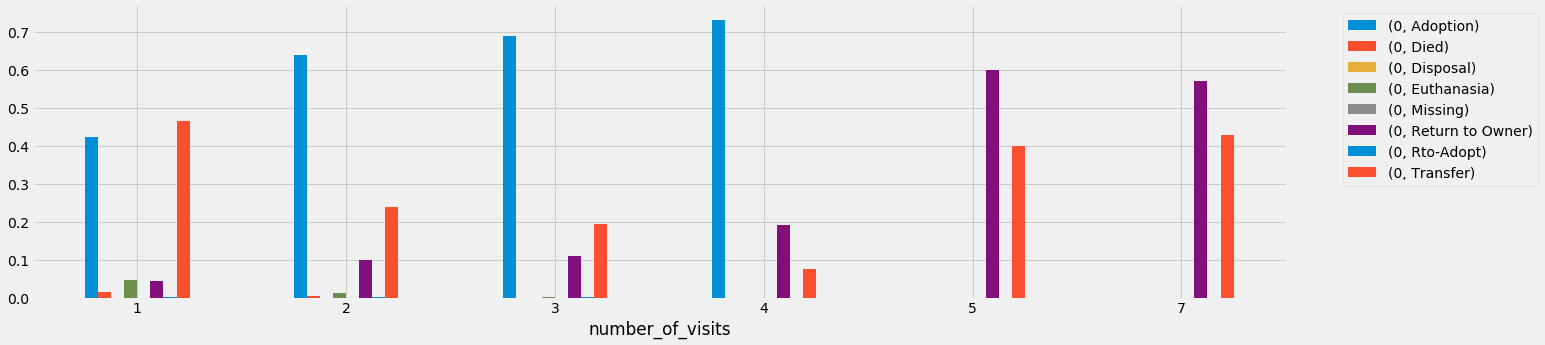

In [71]:
num_of_visits_probabilities = cats_df.groupby('number_of_visits').size().div(len(cats_df))
number_of_visits = cats_df.groupby(['number_of_visits', 'outcome_type']).size().div(len(cats_df)).div(num_of_visits_probabilities)
number_of_visits_df = number_of_visits.to_frame()
plt = number_of_visits_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


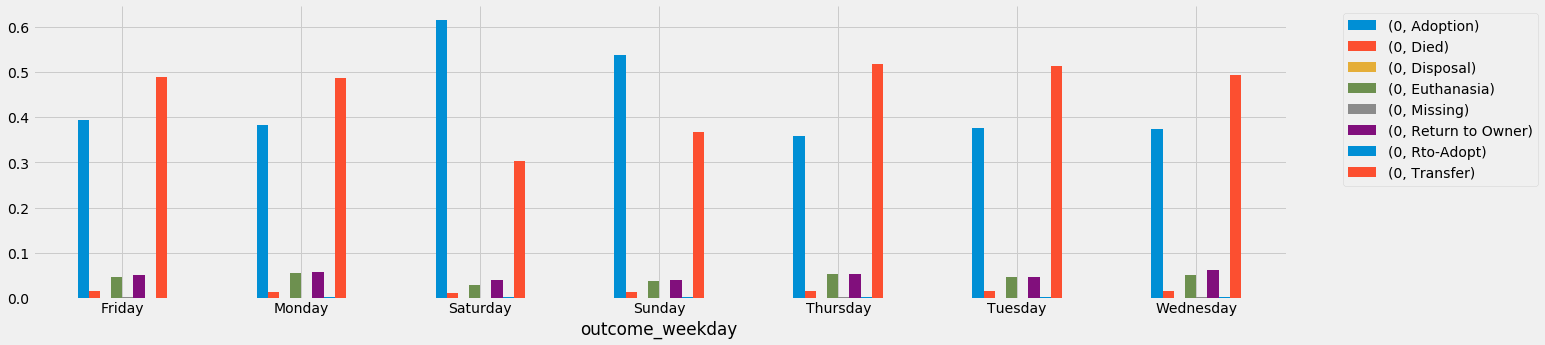

In [72]:
weekday_probabilities = cats_df.groupby('outcome_weekday').size().div(len(cats_df))
weekdays = cats_df.groupby(['outcome_weekday', 'outcome_type']).size().div(len(cats_df)).div(weekday_probabilities)
weekdays_df = weekdays.to_frame()
plt = weekdays_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


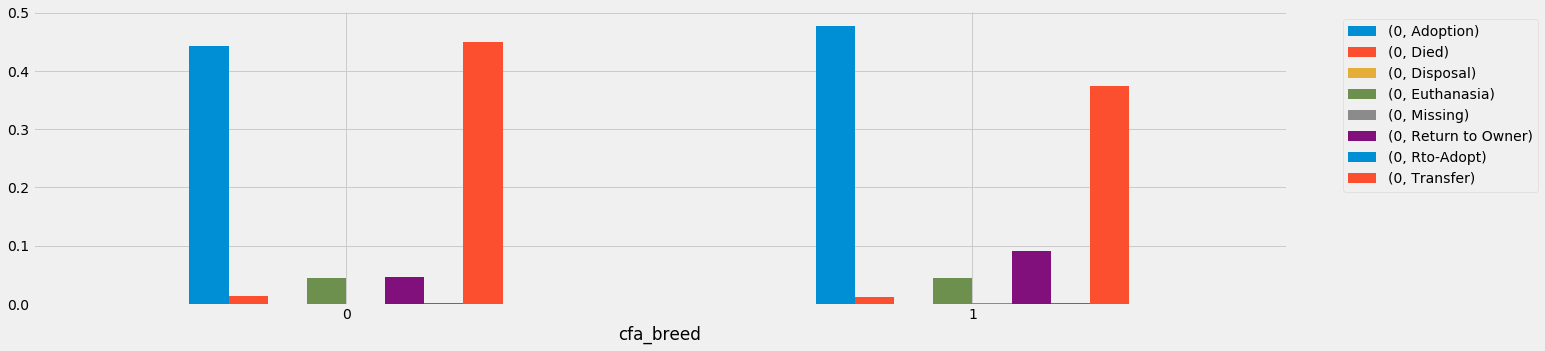

In [73]:
cfa_breed_probabilities = cats_df.groupby('cfa_breed').size().div(len(cats_df))
cfa_breed = cats_df.groupby(['cfa_breed', 'outcome_type']).size().div(len(cats_df)).div(cfa_breed_probabilities)
cfa_breed_df = cfa_breed.to_frame()
plt = cfa_breed_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


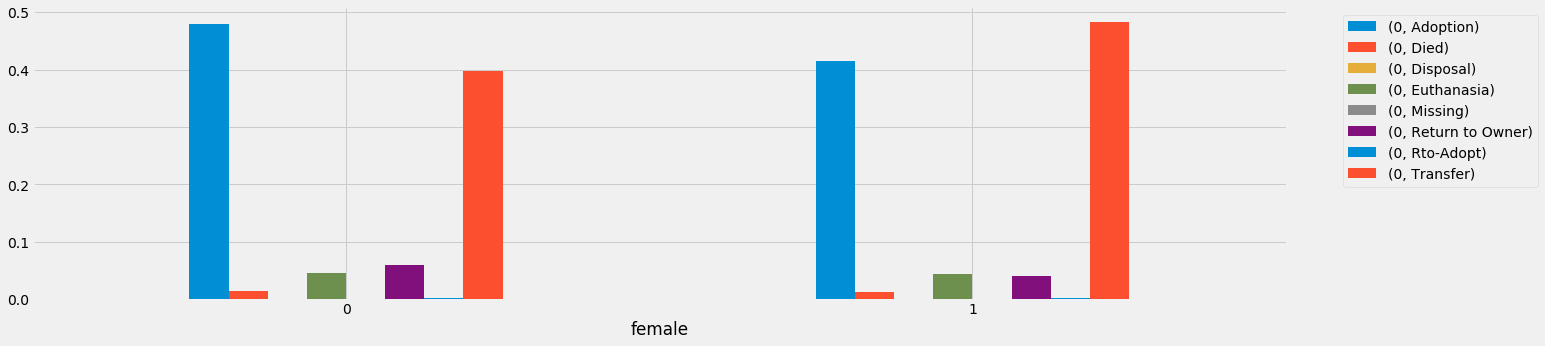

In [74]:
cfa_breed_probabilities = cats_df.groupby('female').size().div(len(cats_df))
cfa_breed = cats_df.groupby(['female', 'outcome_type']).size().div(len(cats_df)).div(cfa_breed_probabilities)
cfa_breed_df = cfa_breed.to_frame()
plt = cfa_breed_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


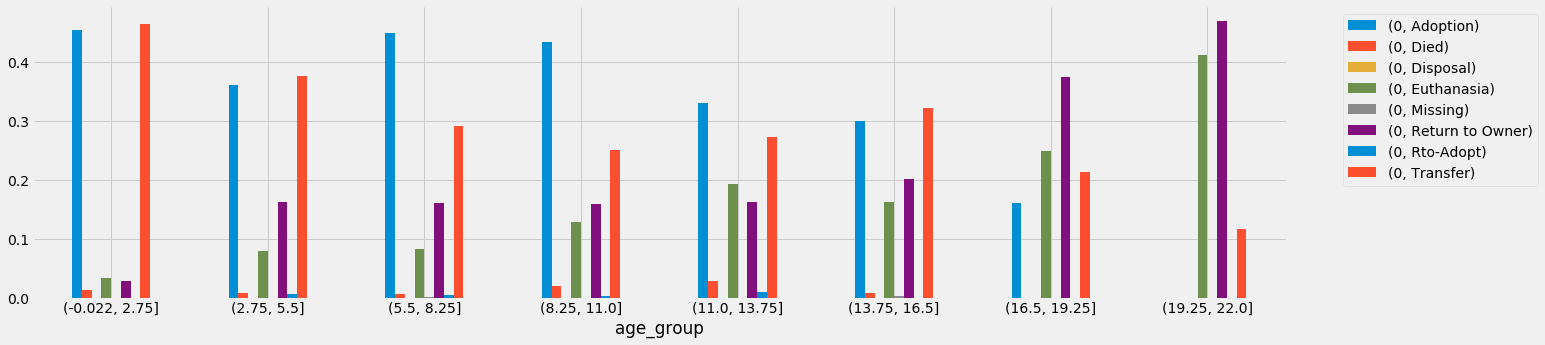

In [75]:
age_group_probabilities = cats_df.groupby('age_group').size().div(len(cats_df))
age_group = cats_df.groupby(['age_group', 'outcome_type']).size().div(len(cats_df)).div(age_group_probabilities)
age_group_df = age_group.to_frame()
plt = age_group_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


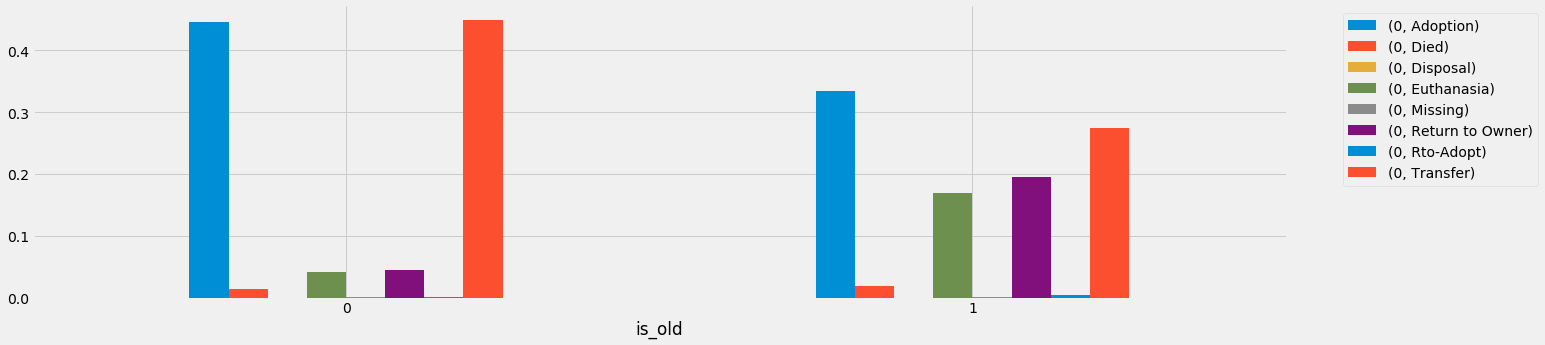

In [76]:
age_group_probabilities = cats_df.groupby('is_old').size().div(len(cats_df))
age_group = cats_df.groupby(['is_old', 'outcome_type']).size().div(len(cats_df)).div(age_group_probabilities)
age_group_df = age_group.to_frame()
plt = age_group_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


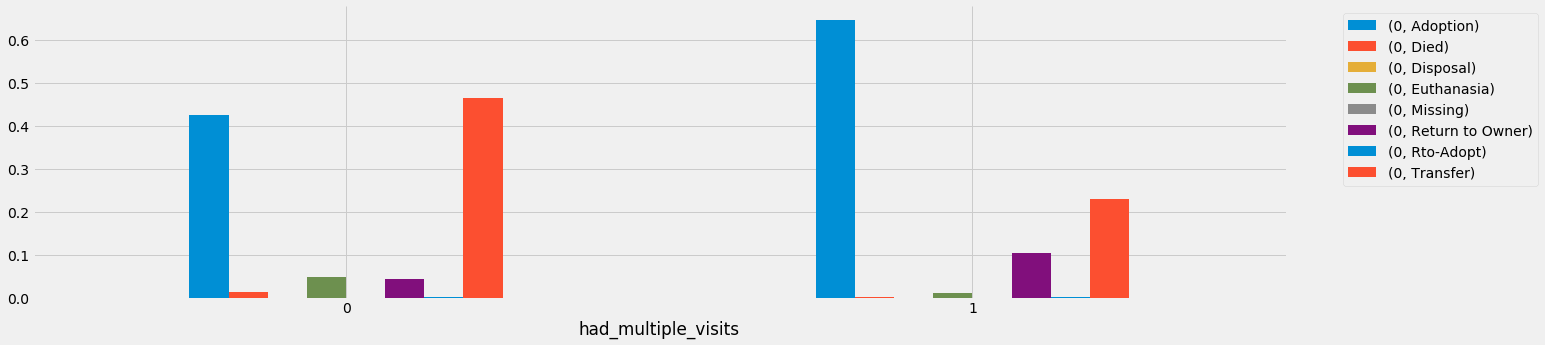

In [77]:
age_group_probabilities = cats_df.groupby('had_multiple_visits').size().div(len(cats_df))
age_group = cats_df.groupby(['had_multiple_visits', 'outcome_type']).size().div(len(cats_df)).div(age_group_probabilities)
age_group_df = age_group.to_frame()
plt = age_group_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


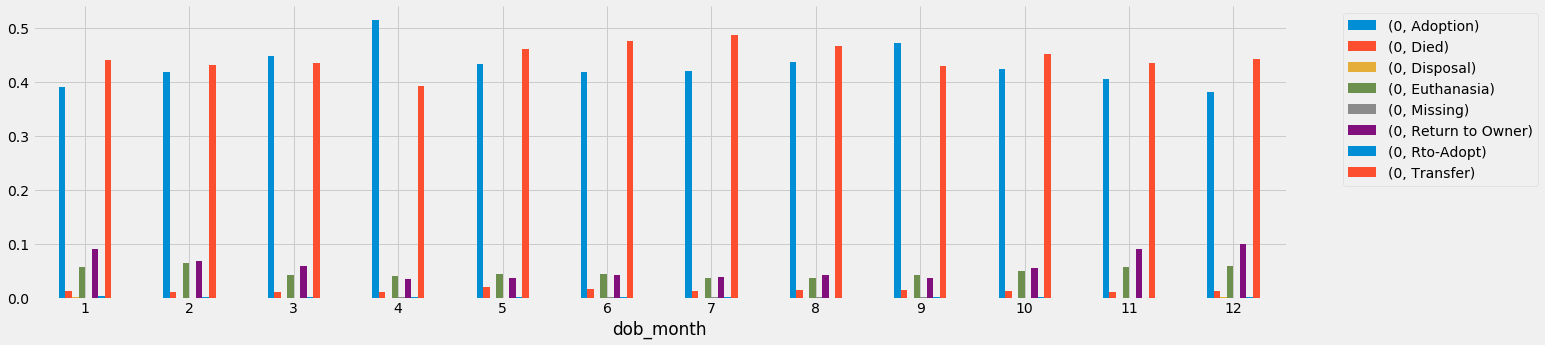

In [78]:
age_group_probabilities = cats_df.groupby('dob_month').size().div(len(cats_df))
age_group = cats_df.groupby(['dob_month', 'outcome_type']).size().div(len(cats_df)).div(age_group_probabilities)
age_group_df = age_group.to_frame()
plt = age_group_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


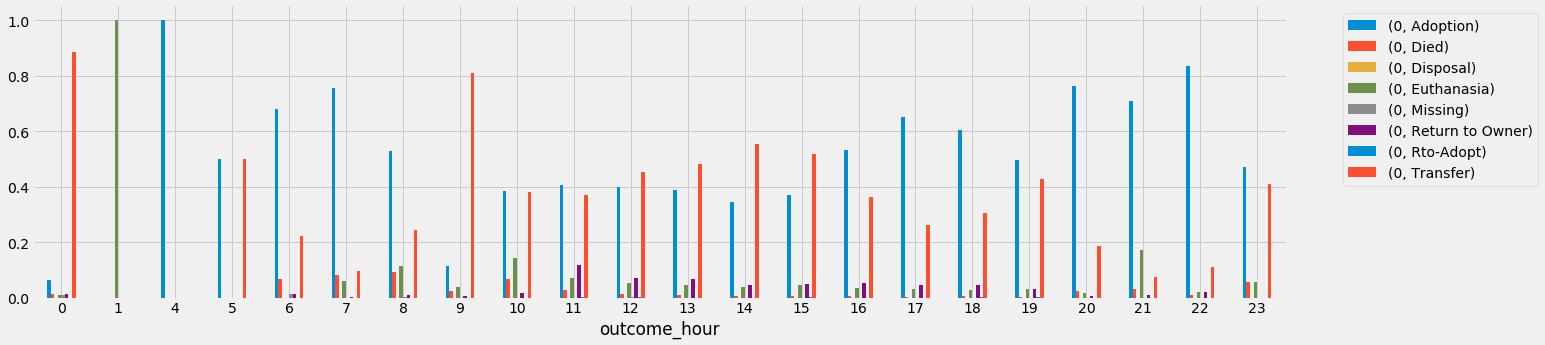

In [79]:
age_group_probabilities = cats_df.groupby('outcome_hour').size().div(len(cats_df))
age_group = cats_df.groupby(['outcome_hour', 'outcome_type']).size().div(len(cats_df)).div(age_group_probabilities)
age_group_df = age_group.to_frame()
plt = age_group_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


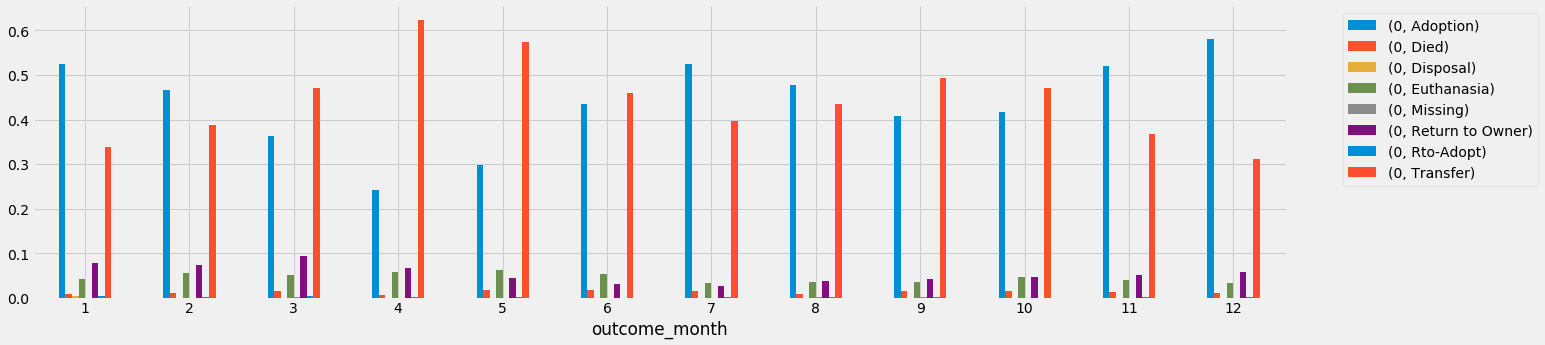

In [80]:
age_group_probabilities = cats_df.groupby('outcome_month').size().div(len(cats_df))
age_group = cats_df.groupby(['outcome_month', 'outcome_type']).size().div(len(cats_df)).div(age_group_probabilities)
age_group_df = age_group.to_frame()
plt = age_group_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


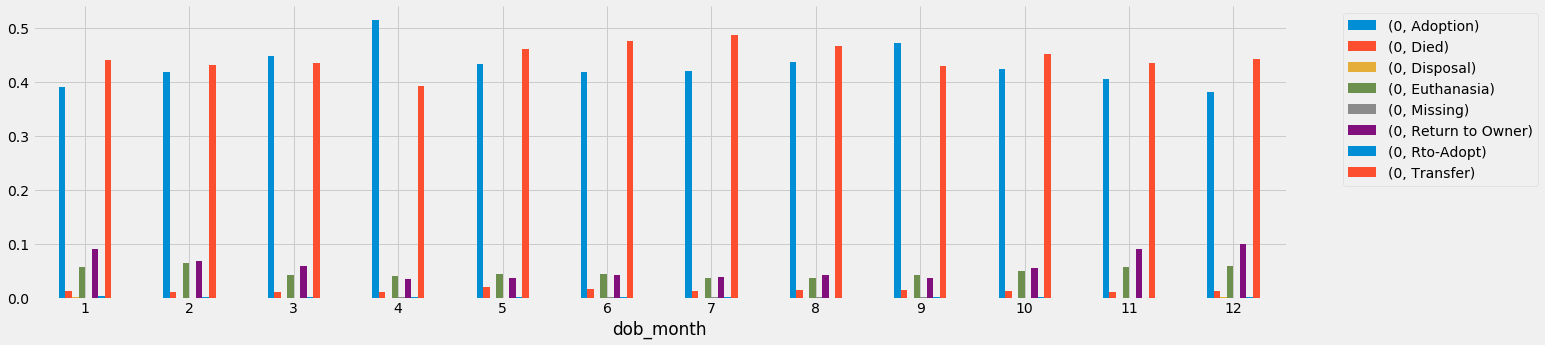

In [81]:
age_group_probabilities = cats_df.groupby('dob_month').size().div(len(cats_df))
age_group = cats_df.groupby(['dob_month', 'outcome_type']).size().div(len(cats_df)).div(age_group_probabilities)
age_group_df = age_group.to_frame()
plt = age_group_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


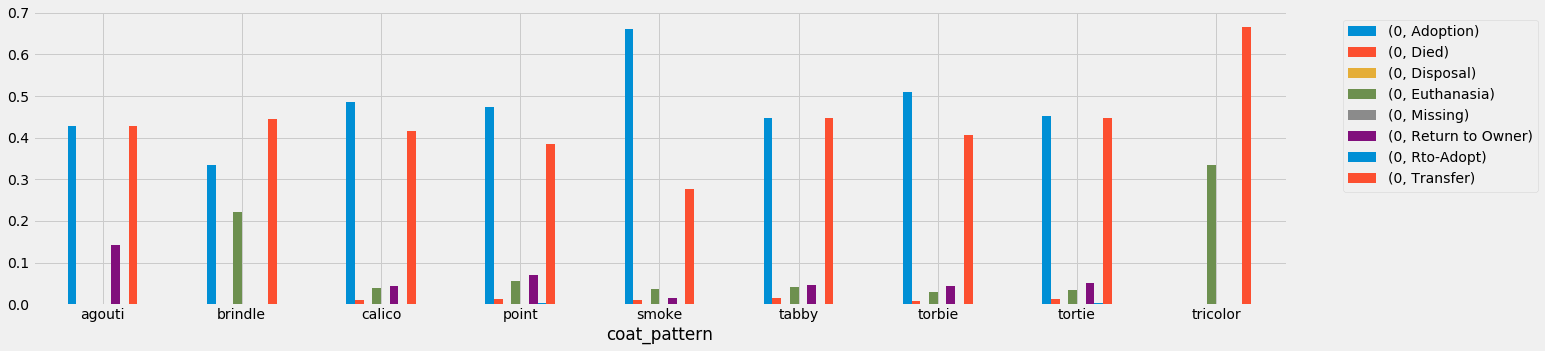

In [82]:
coat_pattern_probabilities = cats_df.groupby('coat_pattern').size().div(len(cats_df))
coat_pattern = cats_df.groupby(['coat_pattern', 'outcome_type']).size().div(len(cats_df)).div(coat_pattern_probabilities)
coat_pattern_df = coat_pattern.to_frame()
plt = coat_pattern_df.unstack('outcome_type').plot.bar(rot=0, linewidth=1, figsize=(20, 5))
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


In [83]:
# ___________________________________________________________________________________________

In [84]:
### lets try some poison

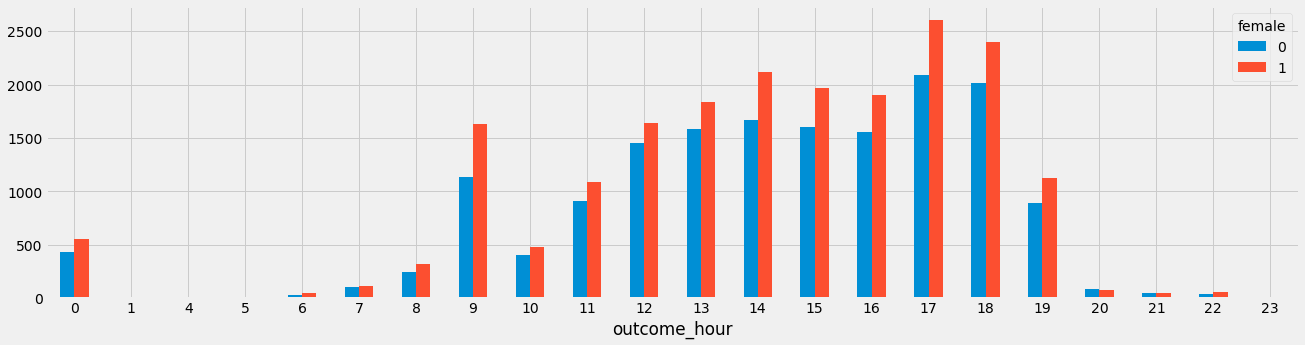

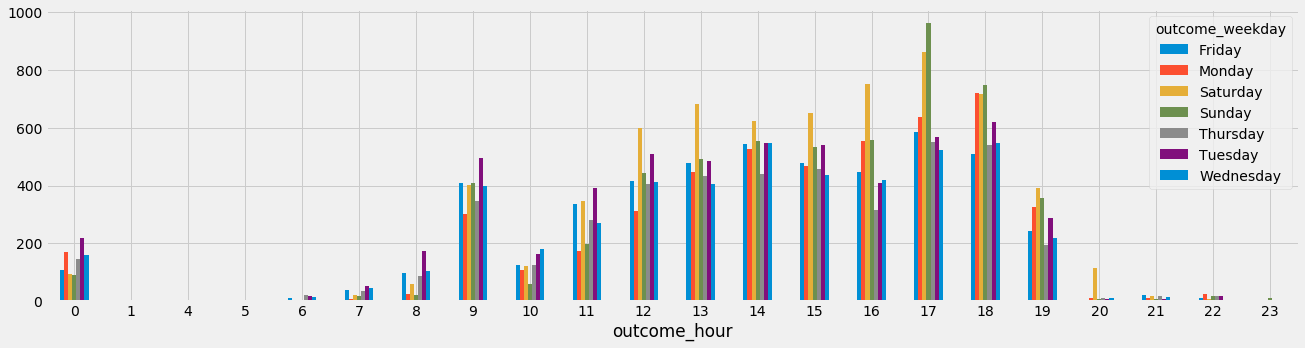

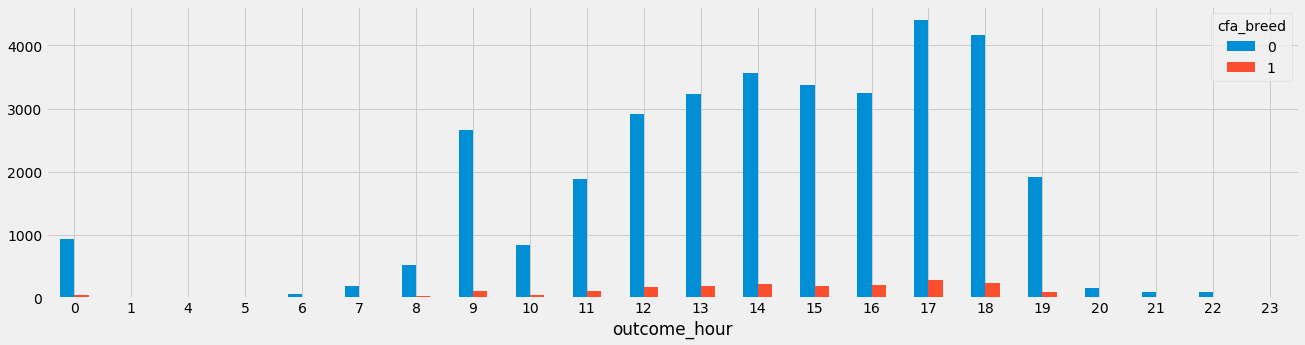

In [85]:
hourly_outcome = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['female'], 
                              values='count', aggfunc=np.sum)

hourly_outcome.plot.bar(rot=0, linewidth=1, figsize=(20, 5))

outcome_weekday = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['outcome_weekday'], 
                              values='count', aggfunc=np.sum)

outcome_weekday.plot.bar(rot=0, linewidth=1, figsize=(20, 5))

cfa_breed = pd.pivot_table(cats_df, 
                              index=['outcome_hour'], columns=['cfa_breed'], 
                              values='count', aggfunc=np.sum)

cfa_breed.plot.bar(rot=0, linewidth=1, figsize=(20, 5))

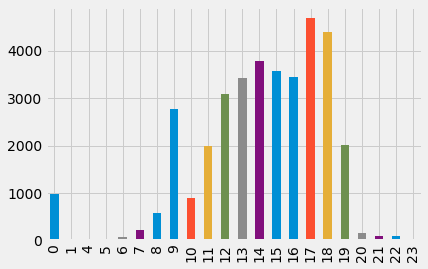

In [86]:
cats_df["outcome_hour"].value_counts().sort_index().plot(kind='bar')

In [87]:
# _____________________________________________________________________________________________________

In [125]:
# Filter out values based on analysis above
filtered_df = cats_df.filter(items=['sex_upon_outcome', 'breed', 'color', 'coat_pattern', 
                               'domestic_breed', 'age_group', 'outcome_month', 
                               'outcome_weekday', 'outcome_hour', 'Cat/Kitten (outcome)', 'number_of_visits'])

In [126]:
### Multinomial Regression on Subtypes
# want to create the following:
# X_TRAIN = [[outcome year, outcome_month, outcome_hour, outcome_age_(years), number_of_visits], ...]
# y_TRAIN = [outcome_type ...]

cats_categorical_df = pd.get_dummies(filtered_df)

In [127]:
cats_categorical_df.head()

,domestic_breed,outcome_month,outcome_hour,number_of_visits,color_,color_/,color_/black,color_/blue,color_/blue cream,color_/brown,...,"age_group_(13.75, 16.5]","age_group_(16.5, 19.25]","age_group_(19.25, 22.0]",outcome_weekday_Friday,outcome_weekday_Monday,outcome_weekday_Saturday,outcome_weekday_Sunday,outcome_weekday_Thursday,outcome_weekday_Tuesday,outcome_weekday_Wednesday
0,1,4,18,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,4,18,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,4,17,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,4,16,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,4,16,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [128]:
for col in cats_categorical_df:
    cats_categorical_df[col] = cats_categorical_df[col].astype('category')

In [129]:
xnames = cats_categorical_df.columns
X_TRAIN = cats_df[['female', 'spayed_or_neutered', 'Kitten', 'outcome_hour', 'outcome_age_(years)', 'number_of_visits']].values.tolist()

In [130]:
Y_TRAIN, ynames = pd.factorize(cats_df['outcome_type'])

In [131]:
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(X_TRAIN)

In [132]:
len(Y_TRAIN)

36303

In [133]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_train_scaled, Y_TRAIN, test_size=0.3)

In [134]:
x_test_scaled = scaler.transform(X_test)

In [135]:
rf_classifier = RandomForestClassifier(n_estimators=250, criterion='gini', 
                                       class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=None, oob_score=True,
            random_state=None, verbose=0, warm_start=False)

In [138]:
import itertools
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.externals import joblib

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [139]:
# DOB month above should not be a relevant metric....

In [140]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)

In [141]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [142]:
y_predicted = model.predict(X_test)
y_predicted.tolist()[0:20]
y_test[0:20]


[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 0])

In [143]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predicted)

In [144]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predicted))

Accuracy: 0.6969057019557433


<Figure size 1080x1080 with 0 Axes>

Normalized confusion matrix


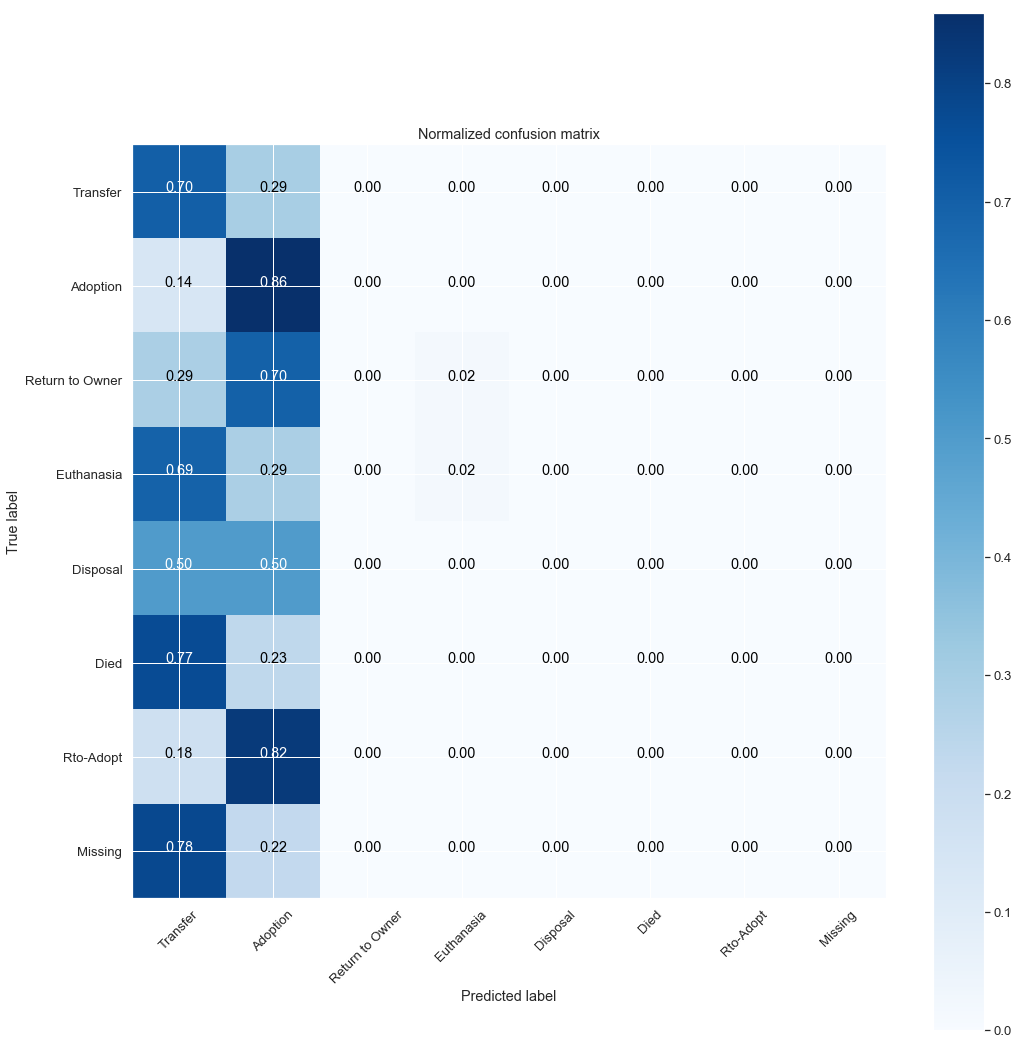

In [145]:
sns.set(font_scale=1.2)

plt.figure(figsize=(15, 15))
plot_confusion_matrix(cm, classes=ynames, normalize=True, title='Normalized confusion matrix')

plt.show()


### Due to the inherint nature of our data source (the majority are adoption and transfer) and mimimal impacts from various variables, a multinomial logistic regression model may not be the right route for classifying outcomes. Interestingly, the majority of the non adopted/transferred outcomes are being classified as a "transfer"

In [522]:
### let's play with random forest and PCA...

In [ ]:
X_TRAIN = np.array(cats_categorical_df)
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(X_TRAIN)

In [ ]:
feature_importances = rf_classifier.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': xnames}, 
                           index=xnames).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

In [523]:
pca = PCA()
pca.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [524]:
print(len(pca.components_))

202


In [ ]:
# 202 variables used above in our analysis... that's quite a bit.

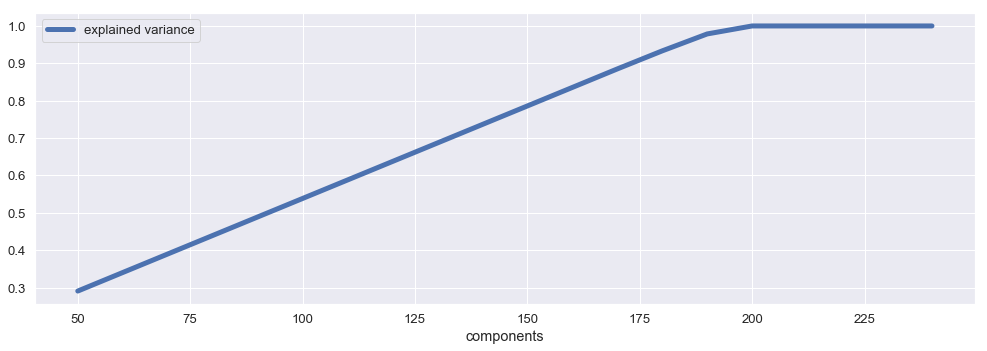

In [525]:
comps = np.arange(50, 250, 10)
exp_var = []

for comp in comps:
    exp_var.append(sum(pca.explained_variance_ratio_[0:comp]))
    
pca_exp_var = pd.concat([pd.Series(comps, name='components'), 
                         pd.Series(exp_var, name='explained variance')], axis=1)

pca_exp_var.set_index('components', inplace=True)

pca_exp_var.plot(kind='line', linewidth=5, figsize=(15, 5))

In [527]:
feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('rf', RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                  class_weight='balanced_subsample', bootstrap=True, 
                                  oob_score=True))
])

In [1]:
prediction_model.fit(x_train_scaled, Y_TRAIN[0:200])

NameError: name 'prediction_model' is not defined

In [531]:
rf_pred = prediction_model.predict(x_test_scaled)

In [532]:
print(accuracy_score(y_test, rf_pred))

0.36447138789381833


<Figure size 792x792 with 0 Axes>

Normalized confusion matrix


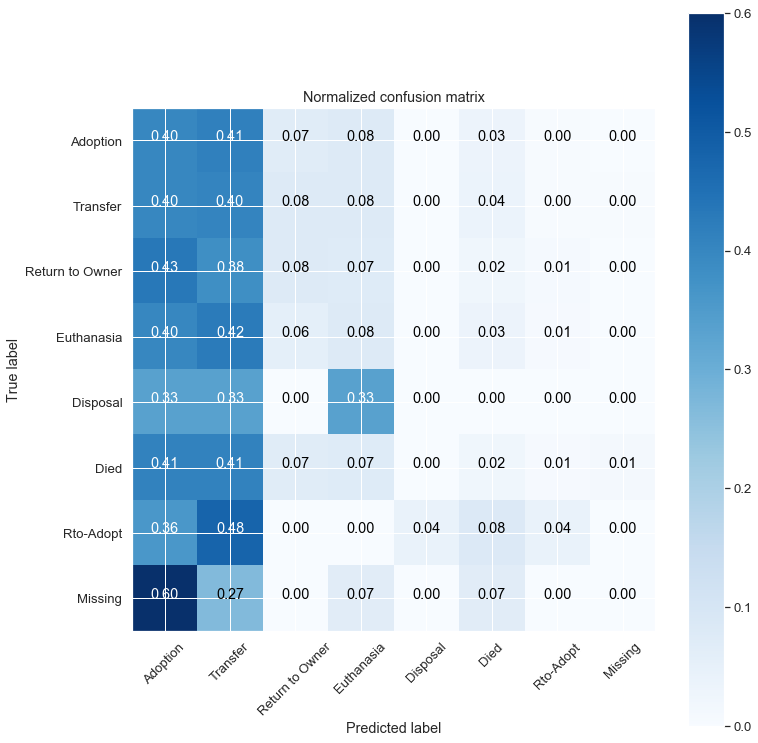

In [536]:
sns.set(font_scale=1.2)

rf_cnf_mat = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(11,11))
plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
print(classification_report(y_test, rf_pred, target_names=ynames))